In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math
import time

from IPython.display import clear_output
%matplotlib inline

from torch.autograd import Variable

torch.set_default_dtype(torch.float64)

import subprocess

In [2]:
PATH = os.getcwd()
print(PATH)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type(torch.DoubleTensor)
    print('Using GPU')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type(torch.DoubleTensor)
    print('Using CPU')
    
    
def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map

print(get_gpu_memory_map())

/home/ct2243/Desktop/RESEARCH_ML/SymplecticNets
Using GPU
{0: 13}


In [3]:
# physics

n_object = 1
n_dim = 1

T = 4

## Network Architectures

In [215]:
# COMPLETE

# takes either (q, t) or (p, t) and outputs a scalar
# perhaps should be named 'symplecticMap', as each mixingNet is a symplectic map

class diagonal_linear(torch.nn.Module):
    def __init__(self, n):
        super(diagonal_linear, self).__init__()
        diag_ = 1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n) - 0.5 )
        self.D = nn.Parameter(torch.diag(diag_), requires_grad=True)
        self.bias = nn.Parameter(1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n) - 0.5 ))
        
    def forward(self, X):
        return torch.mm(X,self.D) + self.bias

    
class symmetric_linear(torch.nn.Module):
    def __init__(self, n):
        super(symmetric_linear, self).__init__()
        self.L = nn.Parameter( 1./torch.sqrt(torch.Tensor([n])) * ( torch.rand(n,n) - 0.5 ) )
        
    def forward(self, X):
        return torch.matmul(X,(self.L.t() + self.L)/2.)
    
    
# irrotational n-hidden layer mixing Net;
class mixingNet(torch.nn.Module):

    def __init__(self, h_sizes, n_object = n_object, n_dim = n_dim):
        super(mixingNet, self).__init__()
        
        # input/output layer, decomposed because need to do weight sharing
        self.linear_t1 = nn.Linear(1,h_sizes[0], bias = False)
        self.qplinear = nn.Linear( (n_object * n_dim), h_sizes[0], bias = False) # nd x nd for n objects in d dimensions.
        self.bias1 = nn.Parameter(1./torch.sqrt(torch.Tensor([h_sizes[0]])) * ( torch.rand(h_sizes[0]) - 0.5 ))
        
        # hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(  diagonal_linear(h_sizes[k])  )

        # skip connection. no need to include t(?)
        self.skip = symmetric_linear((n_object * n_dim)) # nd x nd for n objects in d dimensions.
        self.bias2 = nn.Parameter(torch.rand(1))
        
    def forward(self, q_p, tt):
        act = torch.tanh
        # without linear_t2 seems better.
        residual =  self.skip(q_p) #+self.linear_t2(tt) 
        
        X = act(self.linear_t1(tt) + self.qplinear(q_p) + self.bias1  )
        for layer in self.hidden:
            X = act(layer(X))

        # output layer
        #X = torch.mm(X, self.qplinear.weight) + residual + self.bias2 
        # residual layer seems to make learning slow
        X = torch.mm(X, self.qplinear.weight)  + self.bias2 

        return X


In [174]:
# mixingNet: v2
class mixingNet(torch.nn.Module):

    def __init__(self, h_sizes, n_object = n_object, n_dim = n_dim):
        super(mixingNet, self).__init__()
        
        # input/output layer, decomposed because need to do weight sharing     
        self.linear_t0 = nn.Linear(1,h_sizes[0], bias = False)

        self.linear_t1 = nn.Linear(1,h_sizes[0], bias = True)
        self.linear_t2 = nn.Linear(h_sizes[0], h_sizes[1], bias = True)
        self.linear_t3 = nn.Linear(h_sizes[1], n_object * n_dim, bias = True)

        
        self.qplinear = nn.Linear( (n_object * n_dim), h_sizes[0], bias = False) # nd x nd for n objects in d dimensions.
        self.bias1 = nn.Parameter(1./torch.sqrt(torch.Tensor([h_sizes[0]])) * ( torch.rand(h_sizes[0]) - 0.5 ))
        
        # hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(  diagonal_linear(h_sizes[k])  )

        # skip connection. no need to include t(?)
        self.skip = symmetric_linear((n_object * n_dim)) # nd x nd for n objects in d dimensions.
        self.bias2 = nn.Parameter(torch.rand(1))
        
    def forward(self, q_p, tt):
        #act = torch.nn.Softplus()
        act = torch.tanh
        # without linear_t2 seems better.
        #residual =  self.skip(q_p) #+self.linear_t2(tt) 
        X = act(self.linear_t0(tt) + self.qplinear(q_p) + self.bias1  )
        for layer in self.hidden:
            X = act(layer(X))
            
        t_dep = act(self.linear_t1(tt))
        t_dep = act(self.linear_t2(t_dep))
        t_dep = self.linear_t3(t_dep)


        # output layer
        X = torch.mm(X, self.qplinear.weight) + t_dep  + self.bias2


        return X


In [216]:
class MLP_1_layer(torch.nn.Module):
    def __init__(self, n_hidden = 10):
        super(MLP_1_layer, self).__init__()
        self.input = nn.Linear(1, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, 1)

    def forward(self, X):
        X = torch.tanh(self.input(X) )
        X = torch.tanh(self.hidden(X) )
        X = self.out(X )
        return X

In [217]:
class symplectic_symmetric_Net(torch.nn.Module):
    
    def __init__(self, h_sizes):
        super(symplectic_symmetric_Net, self).__init__()
        
        self.n_transforms = 4
        self.sp_mapsAC = nn.ModuleList()
        self.sp_mapsB = nn.ModuleList()
        
        self.MLPs1 = nn.ModuleList()
        self.MLPs2 = nn.ModuleList()
        self.MLPs3 = nn.ModuleList()

        for k in range(self.n_transforms):
            self.sp_mapsAC.append(  mixingNet(h_sizes)  )
            self.sp_mapsB.append(  mixingNet(h_sizes)  )
            
            self.MLPs1.append(MLP_1_layer(n_hidden = 10))
            self.MLPs2.append(MLP_1_layer(n_hidden = 10))
            self.MLPs3.append(MLP_1_layer(n_hidden = 10))
            
    def forward(self, qq, pp, tt):
        '''
        def symm_transform(m1, m2, M1, M2, M3, qq, pp, dt):
            qq = qq + M1(dt) * dt/2. 
            pp = pp + M2(dt) * dt 
            qq = qq + M3(dt) * dt/2. 
            return qq, pp
        '''
        
        def symm_transform(m1, m2, qq, pp, dt):
            qq = qq + (m1( pp,dt) ) * dt/2#(torch.exp(dt/2.) - 1) 
            pp = pp + m2( qq,dt) * dt#(torch.exp(dt) - 1)
            qq = qq + (m1( pp,dt) ) * dt/2 #  (torch.exp(dt/2.) - 1) 
            return qq, pp
        
        #for m1,m2 in list(zip(self.sp_mapsAC, self.sp_mapsB)):
        for m1, m2, M1, M2, M3 in list(zip(self.sp_mapsAC, self.sp_mapsB, self.MLPs1, self.MLPs2, self.MLPs3)):
            qq, pp = symm_transform(m1, m2, qq, pp, tt/(2* self.n_transforms))
        
        for m1,m2 in reversed(list(zip(self.sp_mapsAC, self.sp_mapsB))):
            qq, pp = symm_transform(m1, m2,  qq, pp, tt/(2* self.n_transforms))
        
        
        return qq, pp

In [218]:
# data
Npoints = 2048
#q0_start = np.random.uniform(-3,3, n_object).reshape((n_object, -1))
#p0_start = np.random.uniform(-3,3, n_object).reshape((n_object, -1))
q0_start = np.array([2]).reshape((n_object, -1))
p0_start = np.array([0]).reshape((n_object, -1))

In [219]:

q0_start = np.repeat(q0_start, Npoints, axis = 1).T
p0_start = np.repeat(p0_start, Npoints, axis = 1).T


In [237]:
# Training
n_train = Npoints
batch_size = int(n_train)

criterion = nn.MSELoss()

lossdata = []

h_sizes = [32] * 2

spTransform = symplectic_symmetric_Net(h_sizes).to(device = device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('number of parameters:')
count_parameters(spTransform)

number of parameters:


10924

In [238]:
num_epochs = 20000
learning_rate = 2e-2

optimizer_spTransform = torch.optim.LBFGS(spTransform.parameters(),lr = learning_rate, history_size = 100, tolerance_change = 1e-16)
#optimizer_spTransform = torch.optim.Adam(spTransform.parameters(),lr = 1e-3)


epoch [20000/20000], loss:0.0004924981487088


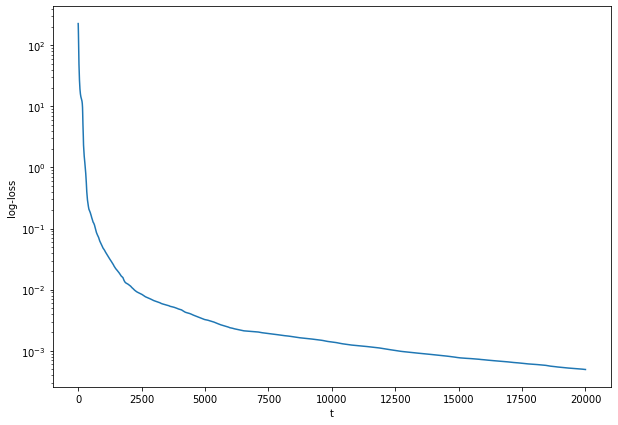

In [239]:
'''
np.random.seed(0)

q0_noise = np.random.uniform(low = -0.01, high = 0.01, size = n_object * Npoints).reshape((-1,n_object))
p0_noise = np.random.uniform(low = -0.01, high = 0.01, size = n_object * Npoints).reshape((-1,n_object))

q0 = q0_start + q0_noise
p0 = p0_start + p0_noise

#t = np.random.uniform(low = 0, high = T, size = Npoints).reshape((-1,1))
t = np.random.uniform(low = 0, high = min(T, T * (epoch + 100)/num_epochs), size = (Npoints)).reshape((-1,1))


shuffle_index = torch.randperm(n_train)

tt_ = torch.Tensor(t.reshape(-1,1))

tt = tt_[shuffle_index].to(device=device)
tt.requires_grad_(True)

theta0_, p0_ = q0, p0
theta0_, p0_ = torch.Tensor(theta0_.reshape(-1,n_object)), torch.Tensor(p0_.reshape(-1,n_object))    
theta0, p0 = theta0_[shuffle_index].to(device=device), p0_[shuffle_index].to(device=device)

theta0.requires_grad_(True), p0.requires_grad_(True)

## required for supervised learning.
#  thetat = torch.Tensor(labels[:,0].reshape(-1,1))[shuffle_index].to(device = device)
#  pt = torch.Tensor(labels[:,1].reshape(-1,1))[shuffle_index].to(device = device)
'''

for epoch in range(num_epochs):
    if epoch % 400 ==0 :
        np.random.seed(0)
        
        q0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
        p0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
        
        q0_noise = 0.2 * np.random.randn( n_object * Npoints).reshape((-1,n_object))
        p0_noise = 0.2 * np.random.randn( n_object * Npoints).reshape((-1,n_object))

        q0 = q0_start + q0_noise
        p0 = p0_start + p0_noise
        
        t = np.random.uniform(low = 0, high = T, size = Npoints).reshape((-1,1))
        #t = np.random.uniform(low = 0, high = min(T, T * (epoch + 400)/num_epochs), size = (Npoints)).reshape((-1,1))


        shuffle_index = torch.randperm(n_train)

        tt_ = torch.Tensor(t.reshape(-1,1))

        tt = tt_[shuffle_index].to(device=device)
        tt.requires_grad_(True)

        theta0_, p0_ = q0, p0
        theta0_, p0_ = torch.Tensor(theta0_.reshape(-1,n_object)), torch.Tensor(p0_.reshape(-1,n_object))    
        theta0, p0 = theta0_[shuffle_index].to(device=device), p0_[shuffle_index].to(device=device)

        theta0.requires_grad_(True), p0.requires_grad_(True)

        ## required for supervised learning.
        #  thetat = torch.Tensor(labels[:,0].reshape(-1,1))[shuffle_index].to(device = device)
        #  pt = torch.Tensor(labels[:,1].reshape(-1,1))[shuffle_index].to(device = device)


    
    for i in range(int(len(tt)/batch_size)):
        
        theta0i = theta0[i*batch_size:(i+1)*batch_size]
        p0i = p0[i*batch_size:(i+1)*batch_size]
        tti = tt[i*batch_size:(i+1)*batch_size]

        # Forward 
        qti, pti = spTransform(theta0i, p0i, tti)
        
        
        
        vec = qti.new(qti.shape).fill_(1)
        d_q_d_t = torch.autograd.grad(qti, tti, vec, create_graph = True, retain_graph = True)[0]
        d_p_d_t = torch.autograd.grad(pti, tti, vec, create_graph = True, retain_graph = True)[0]

                
        # 1. autodiff to get these
        #Hamiltonian =  1/2.* (qti**2 + 1) * (pti**2 +1)
        #d_H_d_p = torch.autograd.grad(Hamiltonian, pti, Hamiltonian.new(Hamiltonian.shape).fill_(1), create_graph = True)[0]
        #d_H_d_q = torch.autograd.grad(Hamiltonian, qti, Hamiltonian.new(Hamiltonian.shape).fill_(1), create_graph = True)[0]
        
        d_H_d_p = pti * (qti**2 + 1)
        d_H_d_q = qti * (pti**2 + 1)
        
        # 2. compute by hand
        #d_H_d_p = pti #p/m # to be precise
        #d_H_d_q = torch.mm(qti, K_tensor.t()) #k*q # to be precise

        loss = criterion(d_q_d_t,  d_H_d_p) + criterion(d_p_d_t, - d_H_d_q) 

        
        # Backward
        def closure():
            return loss

        optimizer_spTransform.zero_grad()
        
        loss.backward(retain_graph = True)
        
        optimizer_spTransform.step(closure)


    lossdata.append(float(loss.data))
    print(loss.data)

    if(epoch ==0):
        print('epoch [{}/{}], loss:{:.16f}'.format(epoch, num_epochs, loss.data))

    if( (epoch+1) % 100 ==0):
        clear_output()
        print('epoch [{}/{}], loss:{:.16f}'.format(epoch + 1, num_epochs, loss.data))
        if(len(lossdata)>10):
            plt.figure(figsize = (10,7))
            plt.xlabel('t')
            plt.ylabel('log-loss')
            plt.semilogy(np.array(lossdata))
            plt.show()

In [242]:
q0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))
p0_noise = np.random.uniform(low = -1, high = 1, size = n_object * Npoints).reshape((-1,n_object))

q0_noise = 0.1 * np.random.randn( n_object * Npoints).reshape((-1,n_object))
p0_noise = 0.1 * np.random.randn( n_object * Npoints).reshape((-1,n_object))





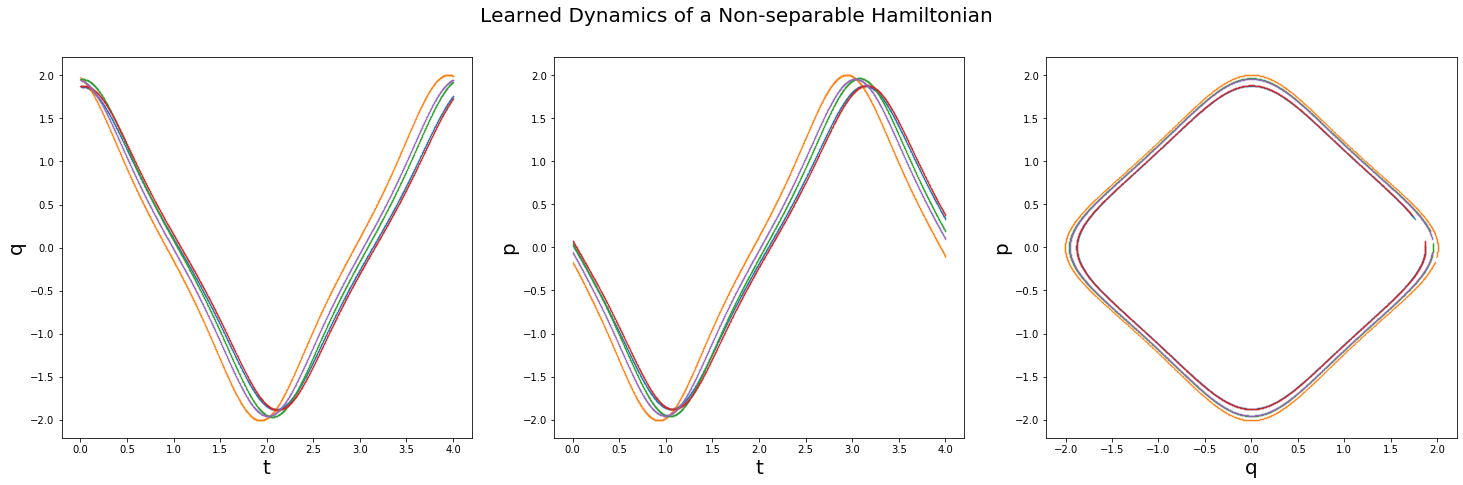

In [253]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,7))

#ax1.set_title('coordinate q Predicted')
#ax2.set_title('momentum p Predicted')
f.suptitle('Learned Dynamics of a Non-separable Hamiltonian', fontsize = 20)
ax1.set_xlabel('t', fontsize = 20)
ax1.set_ylabel('q', fontsize = 20)

ax2.set_xlabel('t', fontsize = 20)
ax2.set_ylabel('p', fontsize = 20)

ax3.set_xlabel('q', fontsize = 20)
ax3.set_ylabel('p', fontsize = 20)



for j in range(5):
    # pick one of the starting points.
    q0_test = (q0_start + q0_noise)[j] 
    p0_test = (p0_start + p0_noise)[j]

    q0_test = q0_test.reshape((-1,1))
    p0_test = p0_test.reshape((-1,1))


    q0_test = torch.Tensor(q0_test.reshape(-1,n_object)).to(device=device)
    p0_test = torch.Tensor(p0_test.reshape(-1,n_object)).to(device=device)

    t_test = (np.arange(Npoints)/(Npoints-1) * T).reshape((-1,1))
    t_test = torch.Tensor(t_test.reshape(-1,1)).to(device=device)

    qt_test, pt_test = spTransform(q0_test, p0_test, t_test)


    for i in range(n_object):
        ax1.scatter(t_test.detach().cpu().numpy(), qt_test[:,i].detach().cpu().numpy(), s = 0.1)
        ax2.scatter(t_test.detach().cpu().numpy(), pt_test[:,i].detach().cpu().numpy(), s = 0.1)
        ax3.scatter(qt_test[:,i].detach().cpu().numpy(), pt_test[:,i].detach().cpu().numpy(), s = 0.1)

